In [33]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


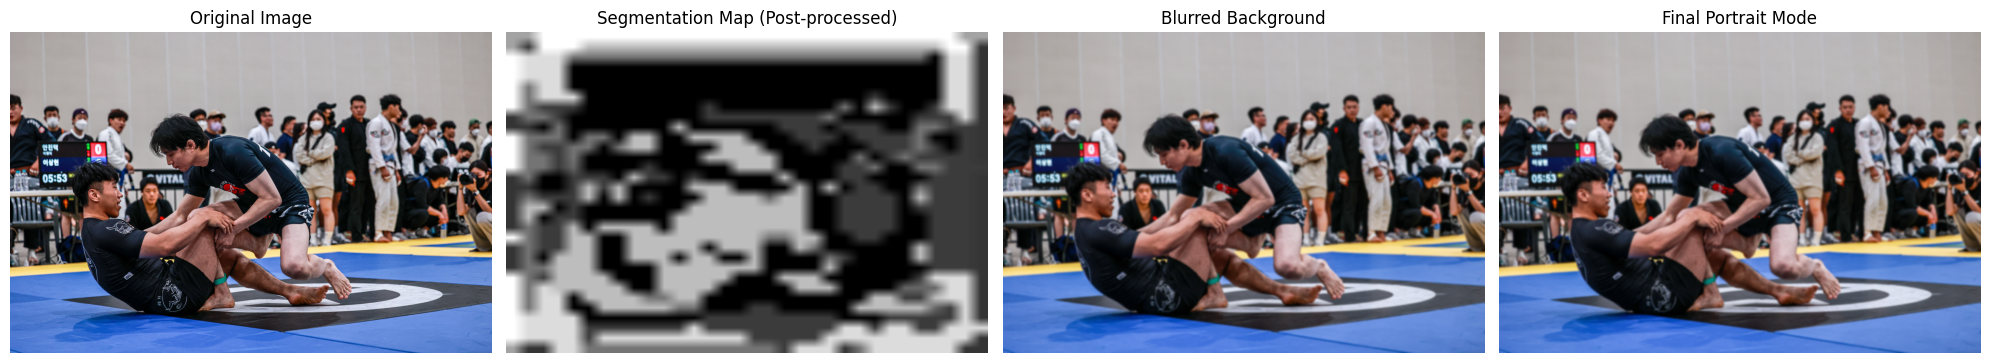

image.jpg 처리가 완료되었습니다. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_deeplabv3\portrait_image.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


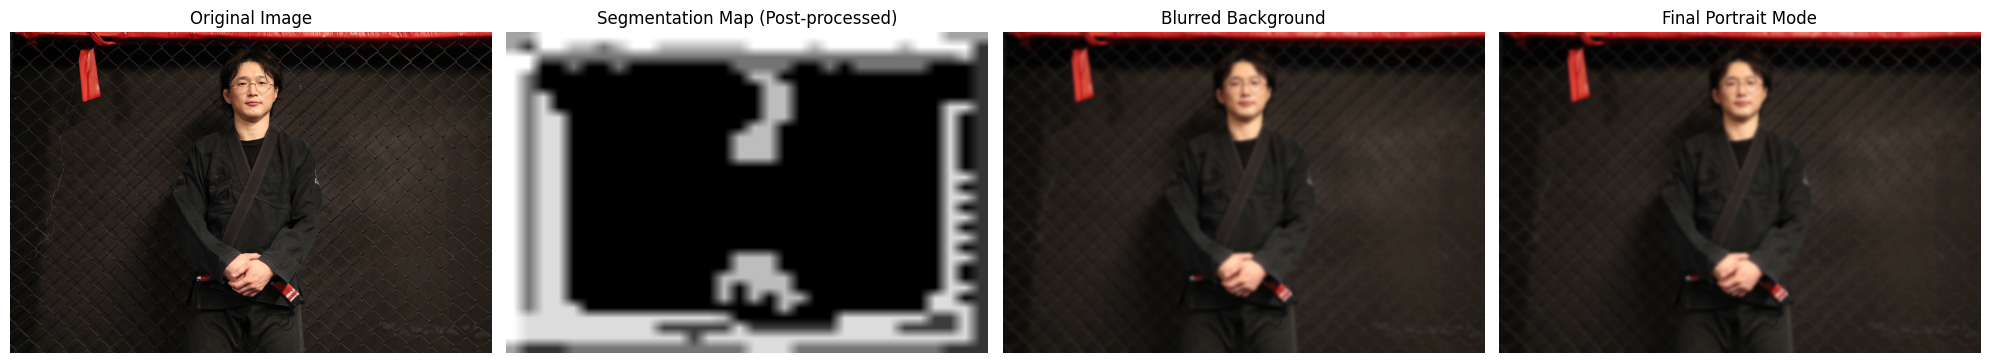

image1.JPG 처리가 완료되었습니다. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_deeplabv3\portrait_image1.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


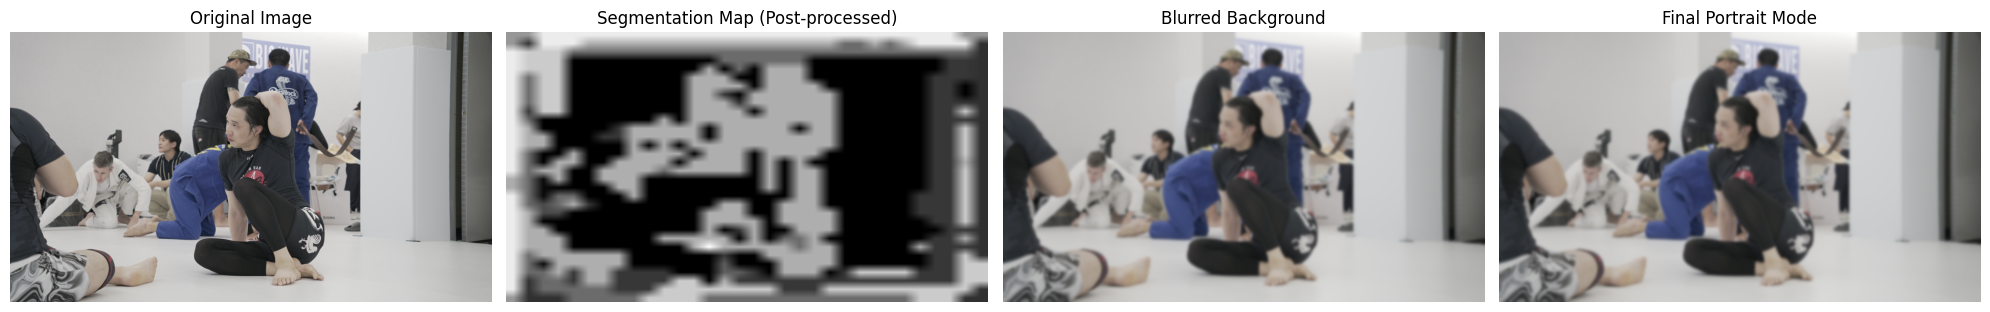

image2.JPG 처리가 완료되었습니다. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_deeplabv3\portrait_image2.JPG
모든 이미지 처리가 완료되었습니다.


In [47]:
# DeepLabV3+ 모델 로드 (ResNet-101 백본 사용, 입력 크기 변경)
model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(1024, 1024, 3))

# 이미지 경로 설정
image_folder = 'C:/Users/envym/workplace/shallo_photo/images'
output_folder = 'C:/Users/envym/workplace/shallo_photo/output_deeplabv3'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    original_size = (image.shape[1], image.shape[0])
    input_image = cv2.resize(image, (1024, 1024))  # 더 큰 해상도로 변경
    input_image = np.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, tf.float32) / 127.5 - 1

    # 모델 예측
    predictions = model.predict(input_image)
    segmentation_map = np.argmax(predictions, axis=-1)[0]

    # 원본 크기로 세그멘테이션 맵 리사이즈
    segmentation_map = cv2.resize(segmentation_map.astype(np.uint8), original_size)

    # 모폴로지 연산 적용 (팽창 후 침식으로 인물 영역 확실히)
    kernel = np.ones((5, 5), np.uint8)
    segmentation_map = cv2.morphologyEx(segmentation_map, cv2.MORPH_CLOSE, kernel)

    # 배경 흐림 처리
    blurred_bg = cv2.GaussianBlur(image, (55, 55), 0)

    # 마스크를 사용하여 인물만 남기기
    # 세그멘테이션 맵에서 인물로 인식된 부분을 남김 (segmentation_map == 사람의 클래스 번호)
    condition = segmentation_map == 15  # 클래스 15가 인물을 나타낸다고 가정

    # 3채널 마스크 생성 (True는 인물, False는 배경)
    mask = np.stack([condition] * 3, axis=-1)

    # 최종 결과 이미지 생성 (인물은 원본, 배경은 흐림 처리된 이미지)
    output_image = np.where(mask, image, blurred_bg)

    # 시각적 비교
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))

    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(segmentation_map, cmap='gray')
    axes[1].set_title("Segmentation Map (Post-processed)")
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(blurred_bg, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Blurred Background")
    axes[2].axis('off')

    axes[3].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    axes[3].set_title("Final Portrait Mode")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    output_path = os.path.join(output_folder, f"portrait_{image_name}")
    cv2.imwrite(output_path, output_image)
    print(f"{image_name} 처리가 완료되었습니다. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")

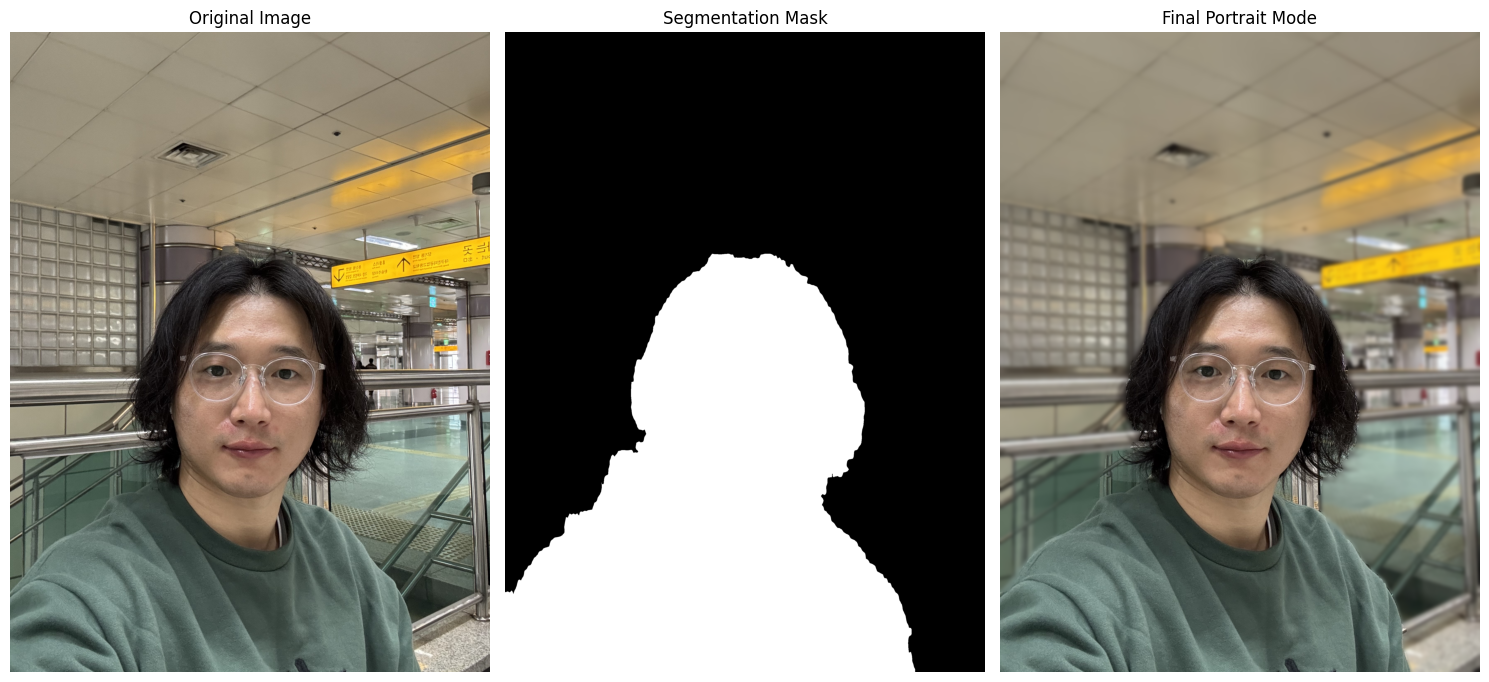

image3.jpg 처리가 완료되었습니다. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_mediapipe\portrait_image3.jpg
모든 이미지 처리가 완료되었습니다.


In [35]:
import mediapipe as mp

# MediaPipe Selfie Segmentation 초기화
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

# 이미지 경로 설정
image_folder = 'C:/Users/envym/workplace/shallo_photo/images'
output_folder = 'C:/Users/envym/workplace/shallo_photo/output_mediapipe'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    # Selfie Segmentation 적용
    results = selfie_segmentation.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # 세그멘테이션 마스크 추출 및 적용
    mask = results.segmentation_mask > 0.5
    mask = np.stack([mask] * 3, axis=-1)  # 3채널 마스크 생성

    # 배경 흐림 처리
    blurred_bg = cv2.GaussianBlur(image, (55, 55), 0)

    # 최종 이미지 생성 (인물은 원본, 배경은 흐림)
    output_image = np.where(mask, image, blurred_bg)

    # 시각적 비교
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))

    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(mask[:, :, 0], cmap='gray')
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Final Portrait Mode")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    output_path = os.path.join(output_folder, f"portrait_{image_name}")
    cv2.imwrite(output_path, output_image)
    print(f"{image_name} 처리가 완료되었습니다. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")


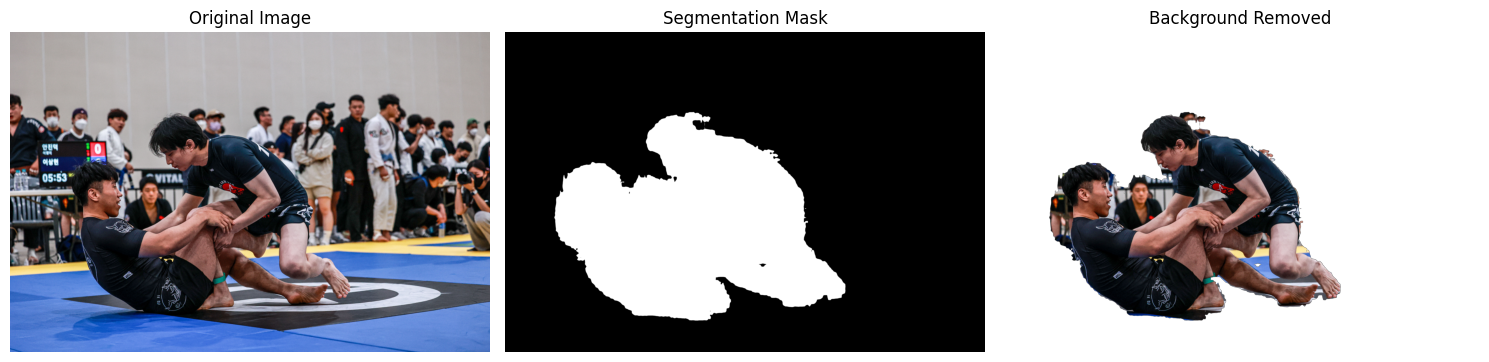

image.jpg 배경 제거 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_only_one\background_removed_image.png


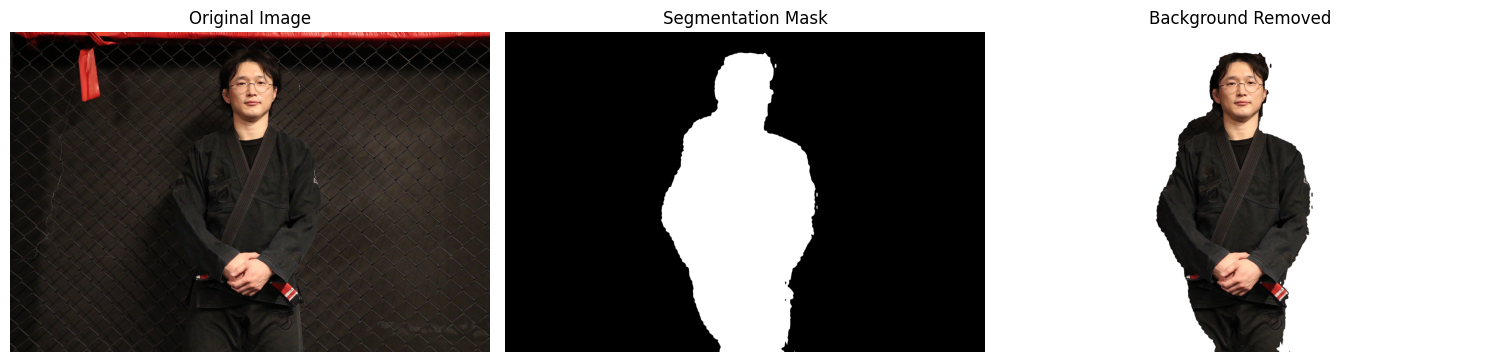

image1.JPG 배경 제거 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_only_one\background_removed_image1.png


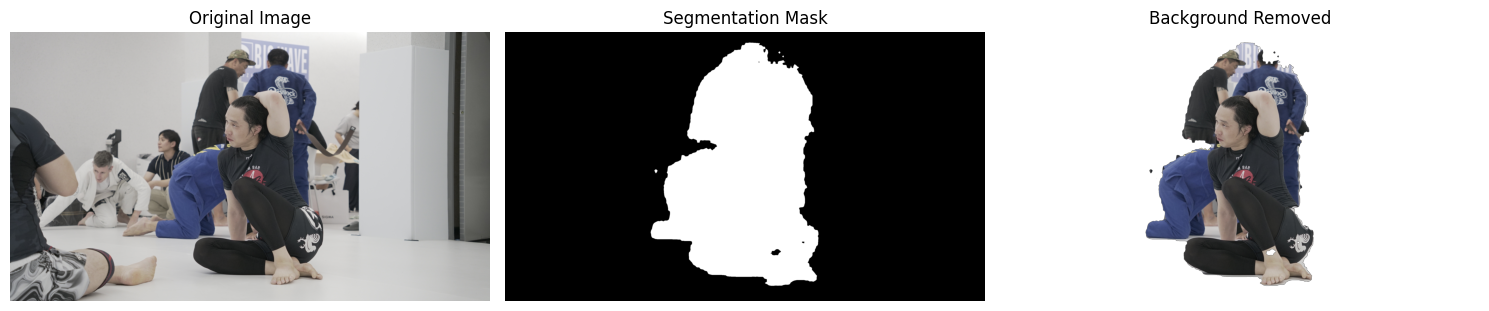

image2.JPG 배경 제거 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_only_one\background_removed_image2.png
모든 이미지 처리가 완료되었습니다.


In [54]:
# MediaPipe Selfie Segmentation 초기화
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

# 이미지 경로 설정
image_folder = 'C:/Users/envym/workplace/shallo_photo/image1'
output_folder = 'C:/Users/envym/workplace/shallo_photo/output_only_one'

# 출력 폴더가 존재하지 않으면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    # Selfie Segmentation 적용
    results = selfie_segmentation.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # 세그멘테이션 마스크 생성
    mask = results.segmentation_mask > 0.5  # True/False로 구성된 마스크
    mask = mask.astype(np.uint8) * 255      # 0 또는 255로 변환 (OpenCV에서 사용하기 위함)
    
    # 인물만 남기기 (배경을 제거하여 투명하게)
    foreground = cv2.bitwise_and(image, image, mask=mask)

    # 투명 배경을 만들기 위해 4채널 이미지 생성 (RGBA)
    bgra_image = cv2.cvtColor(foreground, cv2.COLOR_BGR2BGRA)

    # 투명도를 위해 알파 채널 추가
    alpha_channel = mask
    bgra_image[:, :, 3] = alpha_channel

    # 시각적 비교
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))

    # 원본 이미지
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # 세그멘테이션 마스크
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    # 배경 제거 결과
    axes[2].imshow(cv2.cvtColor(bgra_image, cv2.COLOR_BGRA2RGBA))
    axes[2].set_title("Background Removed")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 저장 (PNG 형식으로 저장해 투명 배경 유지)
    output_path = os.path.join(output_folder, f"background_removed_{image_name.split('.')[0]}.png")
    cv2.imwrite(output_path, bgra_image)
    print(f"{image_name} 배경 제거 완료. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")


C:\Users\envym\AppData\Local\Temp\ipykernel_16668\167555338.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location=torc

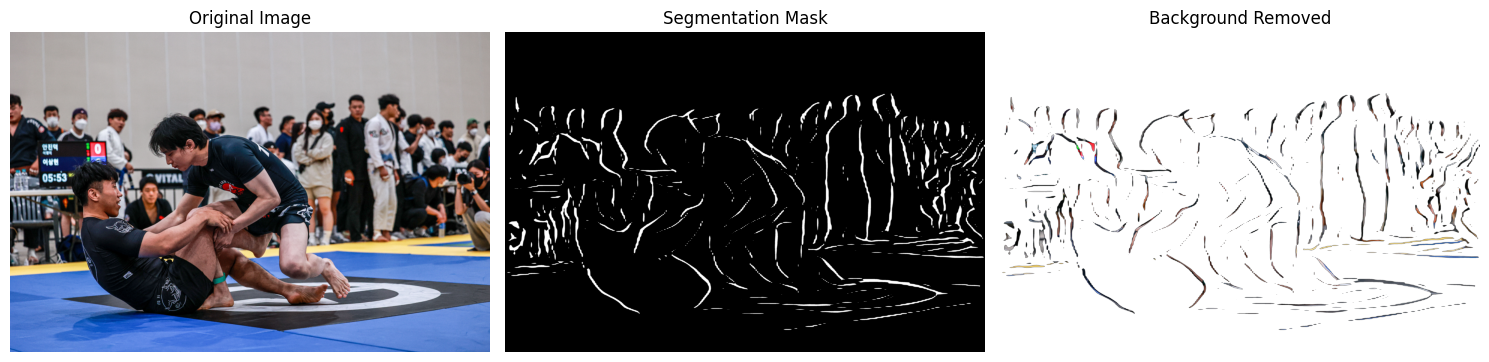

image.jpg 배경 제거 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_u2\background_removed_image.png


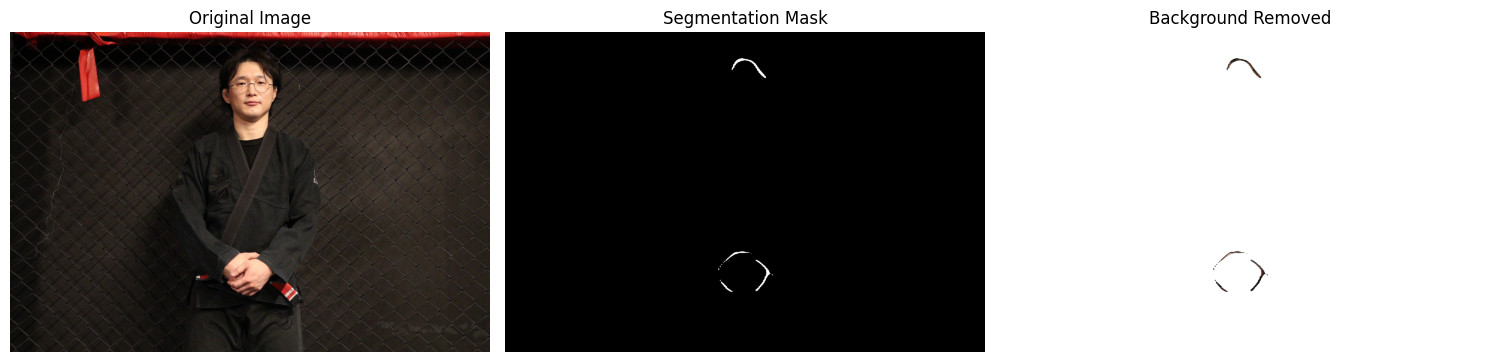

image1.JPG 배경 제거 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_u2\background_removed_image1.png


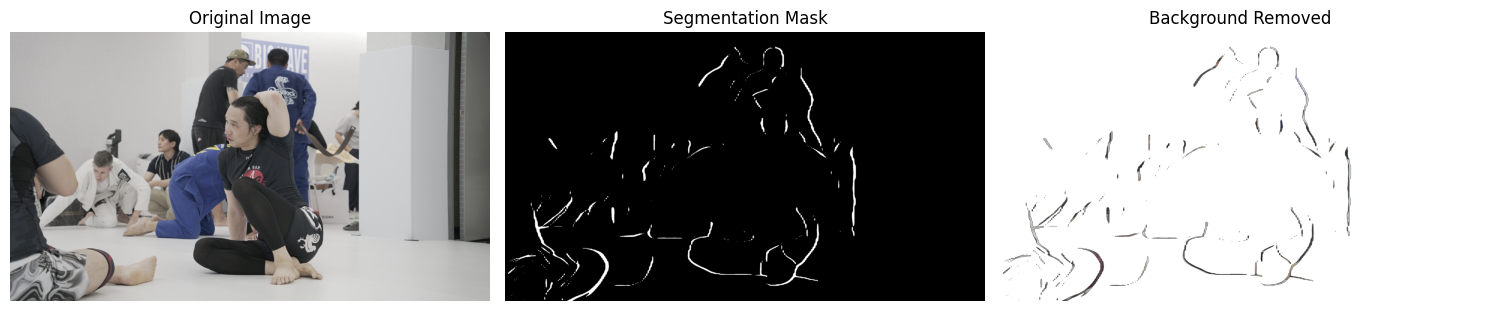

image2.JPG 배경 제거 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_u2\background_removed_image2.png
모든 이미지 처리가 완료되었습니다.


In [53]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# U²-Net 모델 로드
from u2net_portrait_composite import U2NET  # U²-Net 모델을 u2net.py로부터 가져옴 (GitHub에서 제공됨)

# 모델 경로 설정 및 로드
model_path = "C:/Users/envym/workplace/shallo_photo/U2NET.pth"
net = U2NET(3, 1)
net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
net.eval()  # 평가 모드로 설정

# 이미지 경로 설정
image_folder = 'C:/Users/envym/workplace/shallo_photo/image1'
output_folder = 'C:/Users/envym/workplace/shallo_photo/output_u2'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    # 이미지 읽기 및 전처리
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize((320, 320)),
                                    transforms.ToTensor()])
    input_image = transform(image).unsqueeze(0)

    # 모델 예측
    with torch.no_grad():
        output = net(input_image)  # 모델의 전체 출력
        if isinstance(output, tuple):
            d1 = output[0]  # 첫 번째 출력만 사용
        else:
            d1 = output  # 텐서만 반환되는 경우 대비
        prediction = d1[:, 0, :, :]  # 필요한 채널 선택
        prediction = F.interpolate(prediction.unsqueeze(0), size=image.size[::-1], mode='bilinear')
        prediction = prediction.squeeze().cpu().numpy()

    # 세그멘테이션 마스크 생성 (0 ~ 255)
    mask = (prediction * 255).astype(np.uint8)
    mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)[1]  # 이진화 처리

    # 인물만 남기기 (배경을 투명하게 제거)
    image_np = np.array(image)
    foreground = cv2.bitwise_and(image_np, image_np, mask=mask)

    # 투명 배경을 만들기 위해 4채널 이미지 생성 (RGBA)
    bgra_image = cv2.cvtColor(foreground, cv2.COLOR_RGB2BGRA)
    alpha_channel = mask
    bgra_image[:, :, 3] = alpha_channel

    # 시각적 비교
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))

    # 원본 이미지
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # 세그멘테이션 마스크
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    # 배경 제거 결과
    axes[2].imshow(cv2.cvtColor(bgra_image, cv2.COLOR_BGRA2RGBA))
    axes[2].set_title("Background Removed")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 저장 (PNG 형식으로 저장해 투명 배경 유지)
    output_path = os.path.join(output_folder, f"background_removed_{image_name.split('.')[0]}.png")
    cv2.imwrite(output_path, bgra_image)
    print(f"{image_name} 배경 제거 완료. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")


C:\Users\envym\AppData\Local\Temp\ipykernel_16668\3142413494.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location=tor

image3.jpg 초상화 효과 적용 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_u2_portrait\portrait_image3.png


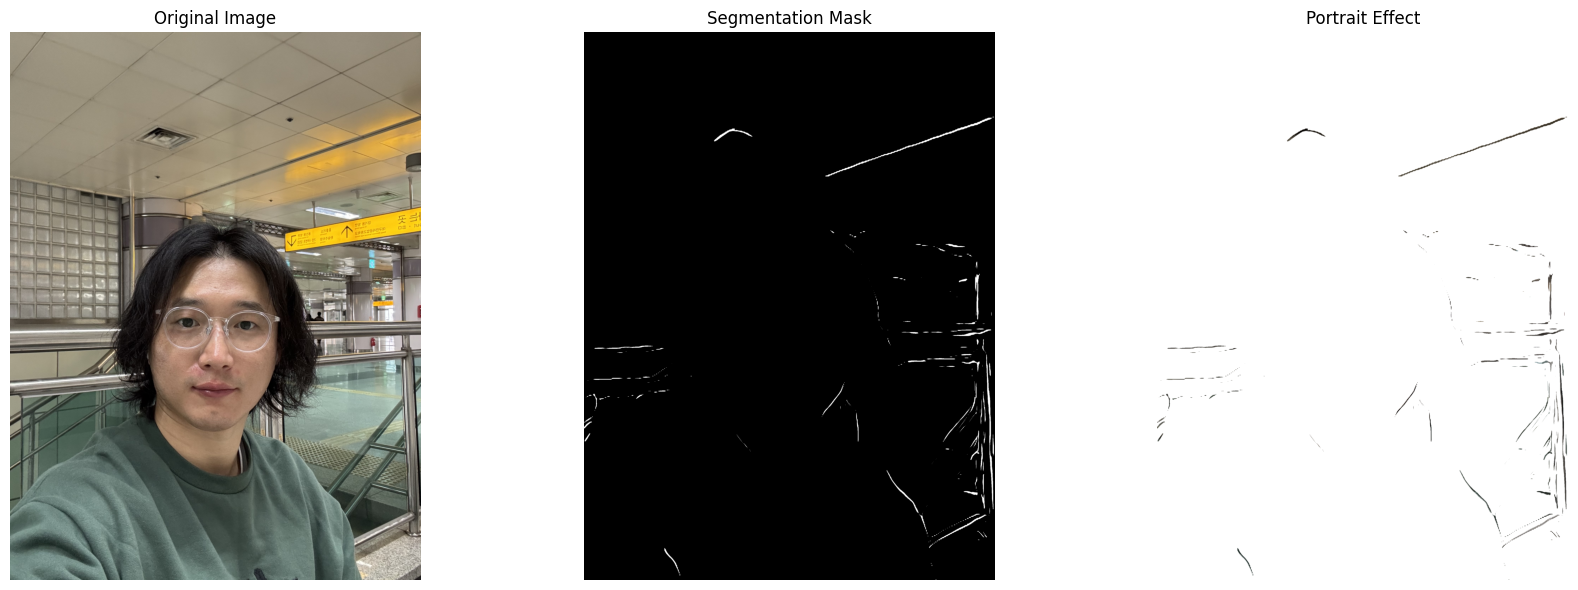

모든 이미지 처리가 완료되었습니다.


In [50]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# U²-Net 모델 로드
from model import U2NET

# 모델 경로 설정 및 로드
model_path = "C:/Users/envym/workplace/shallo_photo/u2net.pth"  # 초상화 모델
net = U2NET(3, 1)
net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
net.eval()

# 이미지 경로 설정
image_folder = 'C:/Users/envym/workplace/shallo_photo/images'
output_folder = 'C:/Users/envym/workplace/shallo_photo/output_u2_portrait'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


def create_portrait_effect(image, mask):
    """
    초상화 효과 적용
    """
    # 윤곽선 추출 (OpenCV의 Canny Edge Detection 사용)
    edges = cv2.Canny(image, 100, 200)

    # 부드러운 배경과 윤곽선 결합
    blurred = cv2.GaussianBlur(image, (15, 15), 0)
    portrait = cv2.addWeighted(blurred, 0.7, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.3, 0)

    # 배경 제거를 위해 알파 채널 추가
    bgra_portrait = cv2.cvtColor(portrait, cv2.COLOR_RGB2BGRA)
    bgra_portrait[:, :, 3] = mask

    return bgra_portrait


# 이미지 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    # 이미지 읽기 및 전처리
    image = Image.open(img_path).convert('RGB')
    original_size = image.size
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    input_image = transform(image).unsqueeze(0)

    # 모델 예측
    with torch.no_grad():
        output = net(input_image)
        d1 = output[0] if isinstance(output, tuple) else output
        prediction = d1[:, 0, :, :]
        prediction = F.interpolate(prediction.unsqueeze(0), size=original_size[::-1], mode='bilinear')
        prediction = prediction.squeeze().cpu().numpy()

    # 세그멘테이션 마스크 생성 (0 ~ 255)
    mask = (prediction * 255).astype(np.uint8)
    mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)[1]

    # 원본 이미지를 Numpy 배열로 변환
    image_np = np.array(image)

    # 초상화 효과 적용
    portrait_image = create_portrait_effect(image_np, mask)

    # 결과 저장
    output_path = os.path.join(output_folder, f"portrait_{image_name.split('.')[0]}.png")
    cv2.imwrite(output_path, portrait_image)
    print(f"{image_name} 초상화 효과 적용 완료. 결과 저장: {output_path}")

    # 결과 시각화
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(portrait_image, cv2.COLOR_BGRA2RGBA))
    axes[2].set_title("Portrait Effect")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

print("모든 이미지 처리가 완료되었습니다.")


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# U²-Net 모델 로드
from u2net_human_seg_test import U2NET

# 모델 경로 설정 및 로드
u2net_model_path = "C:/Users/envym/workplace/shallo_photo/u2net.pth"
net = U2NET(3, 1)
net.load_state_dict(torch.load(u2net_model_path, map_location=torch.device('cpu')))
net.eval()

# 스타일 전이 모델 로드 (VGG19)
vgg = models.vgg19(pretrained=True).features.eval()

# 디렉토리 설정
image_folder = 'C:/Users/envym/workplace/shallo_photo/images'
style_image_path = 'C:/Users/envym/workplace/shallo_photo/portrait.png'  # 스타일 이미지 경로
output_folder = 'C:/Users/envym/workplace/shallo_photo/output_u2_portrait'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


# 유틸리티 함수
def load_image(image, size=None):
    """이미지 로드 및 텐서로 변환"""
    # 이미 Pillow 이미지 객체라면 열지 않고 바로 사용
    if isinstance(image, Image.Image):
        img = image
    else:
        img = Image.open(image).convert("RGB")

    # 크기 조정
    if size:
        img = img.resize((size, size))

    # 텐서로 변환
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transform(img).unsqueeze(0)



def save_image(tensor, path):
    """텐서를 이미지로 저장"""
    image = tensor.clone().detach().squeeze(0)
    image = image.cpu().clamp(0, 1)
    image = transforms.ToPILImage()(image)
    image.save(path)


def get_features(image, model):
    """VGG19를 사용해 특성 추출"""
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # Content Layer
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


def gram_matrix(tensor):
    """Gram Matrix 계산"""
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

def style_transfer(content, style, model, content_weight=1e4, style_weight=1e2, num_steps=300):
    """스타일 전이 구현"""
    # 콘텐츠와 스타일 특성 추출
    content_features = get_features(content, model)
    style_features = get_features(style, model)

    # 스타일의 Gram Matrix 계산
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # 타겟 이미지 초기화
    target = content.clone().requires_grad_(True)
    optimizer = optim.Adam([target], lr=0.003)

    for step in range(num_steps):
        # 타겟 특성 계산
        target_features = get_features(target, model)

        # 콘텐츠 손실 계산
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'].detach()) ** 2)

        # 스타일 손실 계산
        style_loss = 0
        for layer in style_grams:
            target_gram = gram_matrix(target_features[layer])
            style_gram = style_grams[layer].detach()  # 그래프에서 분리
            layer_style_loss = torch.mean((target_gram - style_gram) ** 2)
            _, d, h, w = target_features[layer].shape
            style_loss += layer_style_loss / (d * h * w)

        # 전체 손실 계산
        total_loss = content_weight * content_loss + style_weight * style_loss

        # 역전파 및 그래프 초기화
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # 로그 출력
        if step % 50 == 0:
            print(f"Step {step}/{num_steps}, Total Loss: {total_loss.item()}")

    return target

# 스타일 전이 실행
style_image = load_image(style_image_path, size=512)

for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    # 배경 제거
    image = Image.open(img_path).convert('RGB')
    original_size = image.size
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    input_image = transform(image).unsqueeze(0)

    # U²-Net을 사용해 배경 제거
    with torch.no_grad():
        output = net(input_image)
        d1 = output[0] if isinstance(output, tuple) else output
        prediction = d1[:, 0, :, :]
        prediction = F.interpolate(prediction.unsqueeze(0), size=original_size[::-1], mode='bilinear')
        prediction = prediction.squeeze().cpu().numpy()

    #세그멘테이션 마스크 생성 (0 ~ 255)
    mask = (prediction * 255).astype(np.uint8)
    mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)[1]

    # 마스크 크기 맞추기
    mask = cv2.resize(mask, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 마스크를 8비트 형식으로 변환
    mask = mask.astype(np.uint8)

    # 배경 제거 후 이미지
    foreground = cv2.bitwise_and(image_np, image_np, mask=mask)

    #opencv에서 rgb로 변환
    foreground = Image.fromarray(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))  

    # 바로 load_image 호출 (Image 객체를 직접 전달)
    content_image = load_image(foreground, size=512)

    # 스타일 전이 적용
    styled_image = style_transfer(content_image, style_image, vgg)

    # 결과 저장
    output_path = os.path.join(output_folder, f"styled_{image_name.split('.')[0]}.png")
    save_image(styled_image, output_path)
    print(f"{image_name} 스타일 전이 완료. 결과 저장: {output_path}")

print("모든 이미지 스타일 전이 완료.")


C:\Users\envym\AppData\Local\Temp\ipykernel_16668\1116629920.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(u2net_model_path, map_locati

Step 0/300, Total Loss: 206574.578125
Step 50/300, Total Loss: 156801.78125
Step 100/300, Total Loss: 129413.8671875
Step 150/300, Total Loss: 117110.2265625
Step 200/300, Total Loss: 109163.4765625
Step 250/300, Total Loss: 103145.0625
image3.jpg 스타일 전이 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_u2_portrait\styled_image3.png
모든 이미지 스타일 전이 완료.


Step 0/300, Total Loss: 135439.5
Step 50/300, Total Loss: 80245.8125
Step 100/300, Total Loss: 62695.55078125
Step 150/300, Total Loss: 53196.07421875
Step 200/300, Total Loss: 46847.7890625
Step 250/300, Total Loss: 42366.42578125
스타일 전이 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_u2_portrait/image_portrait123.png


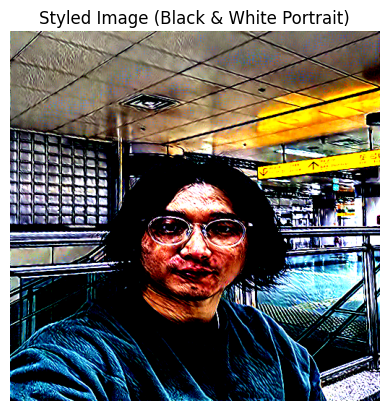

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# 유틸리티 함수
def load_image(image_path, size=None):
    """이미지 로드 및 텐서로 변환"""
    image = Image.open(image_path).convert("RGB")
    if size:
        image = image.resize((size, size))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transform(image).unsqueeze(0)

def save_image(tensor, path):
    """텐서를 이미지로 저장"""
    image = tensor.clone().detach().squeeze(0)
    image = image.cpu().clamp(0, 1)
    image = transforms.ToPILImage()(image)
    image.save(path)

def get_features(image, model):
    """VGG19를 사용해 특성 추출"""
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # Content Layer
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

def gram_matrix(tensor):
    """Gram Matrix 계산"""
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

def style_transfer(content, style, model, content_weight=1e4, style_weight=1e2, num_steps=300):
    """스타일 전이 구현"""
    # 콘텐츠와 스타일 특성 추출
    content_features = get_features(content, model)
    style_features = get_features(style, model)

    # 스타일의 Gram Matrix 계산
    style_grams = {layer: gram_matrix(style_features[layer]).detach() for layer in style_features}

    # 타겟 이미지 초기화
    target = content.clone().requires_grad_(True)
    optimizer = optim.Adam([target], lr=0.003)

    for step in range(num_steps):
        # 타겟 특성 계산
        target_features = get_features(target, model)

        # 콘텐츠 손실 계산
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'].detach()) ** 2)

        # 스타일 손실 계산
        style_loss = 0
        for layer in style_grams:
            target_gram = gram_matrix(target_features[layer])
            style_gram = style_grams[layer]  # 이미 detach 처리됨
            layer_style_loss = torch.mean((target_gram - style_gram) ** 2)
            _, d, h, w = target_features[layer].shape
            style_loss += layer_style_loss / (d * h * w)

        # 전체 손실 계산
        total_loss = content_weight * content_loss + style_weight * style_loss

        # 역전파 및 최적화
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # 로그 출력
        if step % 50 == 0:
            print(f"Step {step}/{num_steps}, Total Loss: {total_loss.item()}")

    return target

# VGG19 모델 로드
vgg = models.vgg19(pretrained=True).features.eval()

# 입력 파일 경로
content_image_path = "C:/Users/envym/workplace/shallo_photo/images/image3.jpg"  # 셀피 이미지 경로
style_image_path = "C:/Users/envym/workplace/shallo_photo/portrait.png"   # 흑백 스케치 스타일 이미지 경로
output_image_path = "C:/Users/envym/workplace/shallo_photo/output_u2_portrait/image_portrait123.png"  # 결과 저장 경로

# 이미지 로드
content_image = load_image(content_image_path, size=512)
style_image = load_image(style_image_path, size=512)

# 스타일 전이 실행
styled_image = style_transfer(content_image, style_image, vgg)

# 결과 저장
save_image(styled_image, output_image_path)
print(f"스타일 전이 완료. 결과 저장: {output_image_path}")

# 결과 시각화
styled_image_pil = Image.open(output_image_path)
plt.imshow(styled_image_pil)
plt.title("Styled Image (Black & White Portrait)")
plt.axis("off")
plt.show()
